## Sensitive Replenishments - A note on modelling uncertainty. 

I hope to illustrate an approach to modeling the uncertainty in building round-the-clock product availability of short-shelf life products while minimizing disposals. The views expressed in the article are personal. 

Some context -  Imagine you own a grocery store and you had to stock up on bread. Every day you have the option to send out an order by the afternoon to the vendor to replenish the stock the next day. Assume a shelf life of 2 days. 

For the sanity of this article, I am going to make that bold move of simplifying the world into 3 major sources of uncertainty -

- Demand today(d_0) - This will allow us to predict the opening stock of the next day. 
- Demand tomorrow(d_1) - This would determine the demand for tomorrow, and the number of excess units for the next day or lost opportunity of sales. 
- Demand day after(d_2) - To help us understand how many of the excess units we will be able to sell out. If demand for the next day is less than the number of excess units, it gets disposed of. 

On some preliminary data analysis, you are able to fit your sales onto a normal distribution with a mean of 60 units and a standard deviation of 14 units. 

Therefore, this is how the problem would look on simplification.

#### Objective Function - Minimize (Lost Opportunity+Disposal)

#### Uncertainty Model - d_0,d_1,d_2 ~ N(mu = 60,sd = 14)

#### Decision Variable  - Assuming we start at a source of certainty of opening stock today of 70 units, how many units would you order for tomorrow? 

Few Simplifications -

- Let us assume the only values d_0,d_1,d_2 can take are - 10,20,30,40,50,60,70,80,90,100,110,120 (12 Cases in Total)
- d_0,d_1,d_2 are independant of each other
- The replenishment is always done at the beginning the demand cycle.

In the code below I aim to do the following - Given 12 cases of sales we would have 12 x 12 x 12 = **1728 possibilities**

( Example - 
- Case 1 - d_0 = 10 units, d_1 = 20 units and d_2 = 110 units Output_1 - disposal_1 = n1, loss_1 = m1
- Case 2 - d_0 = 100 units, d_1 = 80 units and d_2 = 60 units Output_2 - disposal_2 = n2, loss_2 = m2
- ......
- Case 1728 - d_0 = 90 units, d_1 = 10 units and d_2 = 80 units Output_1728 - disposal_1728 = n_1728, loss_1728 = m_1728)

In each of the above cases we would observe n units of disposals, and m units of lost sales due to out of stock. These cases could happen with a certain probability. 

#### Expected_Outcome(opening_stock_today , final_order) 
=  Prob(Outcome_1)*Outcome_1 + Prob(Outcome_2)*Outcome_2 +.......+ Prob(Outcome_1728)*Outcome_1728

##### Therefore, our expected_outcome is a function of opening_stock_today and final order. Given opening_stock_today, we will choose that final order that will optimise expected_outcome

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import numpy as np
from scipy.stats import norm

file_name= "Sales_milk"
milk_town_down= pd.read_csv(file_name +".csv")
df = milk_town_down[milk_town_down['wh_name']== 'Townsquare']

In [2]:
opening_stock_today = 70 
mu = 60 # mean of sales
sd = 14 # standard deviation of sales
final_order=60

### DATA- MODEL Validation

Text(1.7, 30, 'R²=0.95')

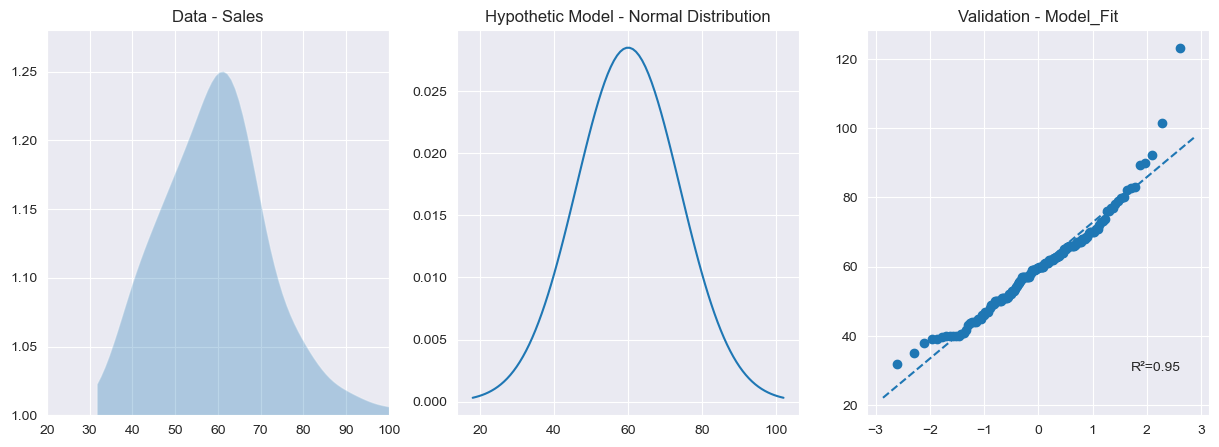

In [3]:
normality_plot, stat = stats.probplot(df['Sales'], rvalue= True) # For Model_Fit
x = np.linspace(mu - 3*sd, mu + 3*sd, 100) #For Normal Distribution
sns.set_style("darkgrid")


def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

fig, axes = plt.subplots(1, 3, figsize=(15,5))

#PLOT 1
axes[0].set_title('Data - Sales')
axes[0].violinplot(df["Sales"],vert=False,showextrema=False)
axes[0].set_ylim(1, 1.28)
axes[0].set_xlim(20, 100)

#PLOT 2
axes[1].set_title('Hypothetic Model - Normal Distribution')
axes[1].plot(x, stats.norm.pdf(x, mu, sd))

#PLOT 3
axes[2].set_title('Validation - Model_Fit')
axes[2].scatter(normality_plot[0],normality_plot[1])
abline(stat[0], stat[1]) 
axes[2].text(1.7,30,"R\u00b2="+str(round(stat[2]**2,2)) )

#### Probability of an independant event based on Model

In [6]:
prob={}
for sales in range(10, 140,10):
    prob[sales]=norm.cdf((sales-mu)/sd)-norm.cdf((sales-10-mu)/sd)
prob=pd.Series(prob)

In [8]:
opening_stock_today = 60
final_order=90
opening_stock_today =int(input("Enter Opening Stock Today [Sample Input=50] - "))
final_order =int(input("Enter Order Quantity [Sample Input=70]- "))
mu = 60 # mean of sales
sd = 14 # standard deviation of sales
# final_order=90

prob={}
for sales in range(10, 130,10):
    prob[sales]=norm.cdf((sales-mu)/sd)-norm.cdf((sales-10-mu)/sd)
prob=pd.Series(prob)

def prob_event (d_0,d_1,d_2):
    return prob[d_0]*prob[d_1]*prob[d_2]

def opening_tomorrow(d_0,order=final_order,opening_today= opening_stock_today):
    return max(opening_today-d_0,0)+order

def calc_disposal(d_0,d_1,d_2):
    tomorrow_excess=opening_tomorrow(d_0)-d_1
    disposal=max(tomorrow_excess-d_2,0)
    return disposal

def calc_sales(d_0,d_1,d_2):
    return min(d_1,opening_tomorrow(d_0))

def calc_oos_loss(d_0,d_1,d_2):
    return max(0,d_1-opening_tomorrow(d_0))


expected_oos_loss=0
expected_disposal=0
expected_sales=0
for d_0 in range(10,130,10):
    for d_1 in range(10,130,10):
        for d_2 in range(10,130,10):
            expected_oos_loss+=prob_event(d_0,d_1,d_2)*calc_oos_loss(d_0,d_1,d_2)
            expected_disposal+=prob_event(d_0,d_1,d_2)*calc_disposal(d_0,d_1,d_2)
            expected_sales+=prob_event(d_0,d_1,d_2)*calc_sales(d_0,d_1,d_2)
            
            
# print("Final Order - ",final_order)
print("expected_oos_loss - ",expected_oos_loss)
print("expected_disposal - ",expected_disposal)
print("expected_sales - ", expected_sales)

Enter Opening Stock Today [Sample Input=50] - 50
Enter Order Quantity [Sample Input=70]- 70
expected_oos_loss -  3.129624385317487
expected_disposal -  0.011907574360151217
expected_sales -  61.86682369643861


#### Therefore, given an opening stock today and a decided final_order for tomorrow, there are 12 possible tomorrows based on the sales_today

In [9]:
summ=0
for d_0 in range(10,130,10):
    for d_1 in range(10,130,10):
        for d_2 in range(10,130,10):
            summ+=prob_event(d_0,d_1,d_2)
print("Sum of Probability of all events = ", summ)

Sum of Probability of all events =  0.9999453551039359


###### Optimal Final Order

In [11]:
mu = 60 # mean of sales
sd = 30 # standard deviation of sales
opening_stock_today =int(input("Enter Opening Stock Today[Sample input 50] - "))
order_cases = pd.DataFrame()
orders= [i for i in range(10,130,10)]
exp_disp=[]
exp_oos=[]
exp_sales=[]
print("Mean - ", mu)
print("sd - ",sd)


for order in range(10,130,10):
    final_order=order
    
    prob={}
    for sales in range(10, 130,10):
        prob[sales]=norm.cdf((sales-mu)/sd)-norm.cdf((sales-10-mu)/sd)
    prob=pd.Series(prob)

    def prob_event (d_0,d_1,d_2):
        return prob[d_0]*prob[d_1]*prob[d_2]

    def opening_tomorrow(d_0,order=final_order,opening_today= opening_stock_today):
        return max(opening_today-d_0,0)+order

    def calc_disposal(d_0,d_1,d_2):
        tomorrow_excess=opening_tomorrow(d_0)-d_1
        disposal=max(tomorrow_excess-d_2,0)
        return disposal

    def calc_sales(d_0,d_1,d_2):
        return min(d_1,opening_tomorrow(d_0))

    def calc_oos_loss(d_0,d_1,d_2):
        return max(0,d_1-opening_tomorrow(d_0))
    
    expected_oos_loss=0
    expected_disposal=0
    expected_sales=0
    for d_0 in range(10,130,10):
        for d_1 in range(10,130,10):
            for d_2 in range(10,130,10):
                expected_oos_loss+=prob_event(d_0,d_1,d_2)*calc_oos_loss(d_0,d_1,d_2)
                expected_disposal+=prob_event(d_0,d_1,d_2)*calc_disposal(d_0,d_1,d_2)
                expected_sales+=prob_event(d_0,d_1,d_2)*calc_sales(d_0,d_1,d_2)
    exp_disp.append(expected_disposal)
    exp_sales.append(expected_sales)
    exp_oos.append(expected_oos_loss)


#     print("Opening_Stock_Today - ",opening_stock_today)
#     print("Final Order - ",final_order)
#     print("expected_oos_loss - ",expected_oos_loss)
#     print("expected_disposal - ",expected_disposal)
#     print("expected_sales - ", expected_sales)

order_cases['Final Order'] = orders
order_cases['expected_oos_loss'] = exp_oos
order_cases['expected_oos_loss'] = round(order_cases['expected_oos_loss'],2)
order_cases['expected_disposal'] = exp_disp
order_cases['expected_disposal'] = round(order_cases['expected_disposal'],2)
order_cases['expected_sales'] = exp_sales
order_cases['expected_sales'] = round(order_cases['expected_sales'],2)
order_cases['% Disposal'] =round((order_cases['expected_disposal']/order_cases['expected_sales'])*100,2)
order_cases['% OOS_Loss'] =round((order_cases['expected_oos_loss']/order_cases['expected_sales'])*100,2)

display(order_cases)

Enter Opening Stock Today[Sample input 50] - 50
Mean -  60
sd -  30


,Final Order,expected_oos_loss,expected_disposal,expected_sales,% Disposal,% OOS_Loss
0,10,43.93,0.00,12.59,0.00,348.93
1,20,35.74,0.02,20.79,0.10,171.91
2,30,28.04,0.05,28.48,0.18,98.46
3,40,21.06,0.12,35.47,0.34,59.37
4,50,14.99,0.28,41.53,0.67,36.09
5,60,10.01,0.58,46.51,1.25,21.52
6,70,6.18,1.12,50.35,2.22,12.27
7,80,3.45,1.99,53.07,3.75,6.50
8,90,1.69,3.34,54.84,6.09,3.08
9,100,0.67,5.28,55.86,9.45,1.20


### Plotting Optimal Order

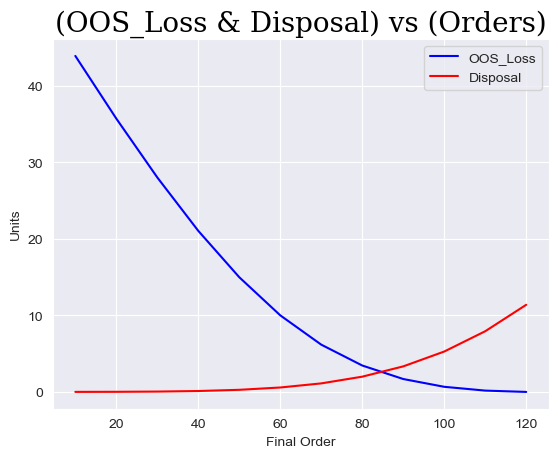

In [12]:
# fig = plt.figure(figsize=(10, 10)

font1 = {'family':'serif','color':'Black','size':20}

plt.title('(OOS_Loss & Disposal) vs (Orders)', fontdict = font1)
plt.plot(orders, exp_oos, "-b",label="OOS_Loss")
plt.plot(orders, exp_disp,"-r",label="Disposal")

plt.rcParams["figure.figsize"] = (6,6)
plt.xlabel("Final Order")
plt.ylabel("Units")
plt.legend(loc="upper right")

plt.show()

In [13]:
opening_stock_tomorrow =prob.to_frame()
opening_stock_tomorrow.reset_index(inplace=True)
opening_stock_tomorrow= opening_stock_tomorrow.rename(columns = {'index':'Sales_DayAfter',0:'Probability'})
# opening_stock_tomorrow['opening_tomorrow']=opening_stock_today-opening_stock_tomorrow['Sales_Today']
# opening_stock_tomorrow['opening_tomorrow'][opening_stock_tomorrow['opening_tomorrow'] < 0] = 0
# opening_stock_tomorrow['opening+order']=opening_stock_tomorrow['opening_tomorrow']+final_order
opening_stock_tomorrow

,Sales_DayAfter,Probability
0,10,0.025040
1,20,0.043421
2,30,0.067444
3,40,0.093837
4,50,0.116949
5,60,0.130559
6,70,0.130559
7,80,0.116949
8,90,0.093837
9,100,0.067444


In [56]:
calc_oos_loss(30,60,10)

0

In [57]:
calc_sales(30,60,10)

60

In [32]:
calc_oos_loss(40,120,80)*prob_event(40,120,80)

0.0

In [51]:
prob_event(d_0=30,d_1=60,d_2=80)

0.000588304656399348

In [ ]:
d_0 = 10 units, d_1 = 20 units and d_2 = 110 units